In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [40]:
# 2D Gaussian Mixture Model

radius = 3.0
means = torch.tensor([
    [ radius, 0.0],
    [ 0.0,  radius],
    [-radius, 0.0],
    [ 0.0, -radius],
    [ 0.0,  0.0],
], dtype=torch.float32)

stds = torch.tensor([0.15, 0.15, 0.15, 0.15, 0.20], dtype=torch.float32)
weights = torch.ones(len(means)) / len(means)

def sample_gmm(n_samples):
    
    comp_idx = torch.multinomial(weights, num_samples=n_samples, replacement=True)
    x = torch.zeros(n_samples, 2)
    for k in range(len(means)):
        mask = (comp_idx == k)
        if mask.any():
            x[mask] = means[k] + stds[k] * torch.randn(mask.sum(), 2)
    return x

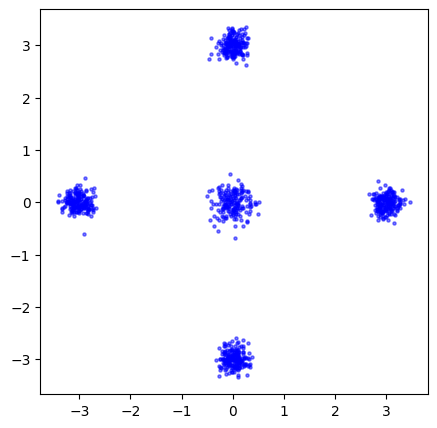

In [41]:
# plot samples

plt.figure(figsize=(5,5))
x = sample_gmm(1000)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5
              , color='blue')


plt.show()

In [42]:

def c_gamma(gamma, a=0.8, lam=4.0):
    c = torch.where(gamma <= a, torch.ones_like(gamma),
                    (1 - gamma) / (1 - a))
    return lam * c


def sample_eqm_batch(n_samples):
   
    x = sample_gmm(n_samples)
    eps = torch.randn_like(x)
    gamma = torch.rand(n_samples, 1)
    
    x_gamma = gamma * x + (1 - gamma) * eps
    c = c_gamma(gamma)
    target = (eps - x) * c
    
    return x, eps, gamma, x_gamma, target

In [43]:
class EqMField(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=3):
        super().__init__()
        layers = []
        in_dim, out_dim = 2, 2

        dims = [in_dim] + [hidden_dim] * num_layers + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.GELU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
f_theta = EqMField(hidden_dim=128, num_layers=3).to(device)
optimizer = optim.Adam(f_theta.parameters(), lr=1e-3)

In [44]:
import os
os.makedirs("eqm_frames", exist_ok=True)

@torch.no_grad()
def save_frame(f_model, step, rng=(-4,4), res=200, step_lvl=5.0, arrow_scale=40, density=20):
    xs = torch.linspace(rng[0], rng[1], res)
    ys = torch.linspace(rng[0], rng[1], res)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    F = f_model(grid)
    E = 0.5 * (F**2).sum(dim=1)
    Z = E.view(res, res).cpu().numpy()
    maxE = np.percentile(Z, 99)
    levels = np.arange(0, maxE, step_lvl)
    plt.figure(figsize=(6,6))
    plt.contour(X.cpu(), Y.cpu(), Z, levels=levels, colors="black", linewidths=0.6)

    xs_a = torch.linspace(rng[0], rng[1], density)
    ys_a = torch.linspace(rng[0], rng[1], density)
    Xa, Ya = torch.meshgrid(xs_a, ys_a, indexing="xy")
    grid_a = torch.stack([Xa.flatten(), Ya.flatten()], dim=1).to(device)
    Fa = f_model(grid_a).cpu()
    plt.quiver(grid_a[:,0], grid_a[:,1], -Fa[:,0], -Fa[:,1],
               angles="xy", scale_units="xy", scale=arrow_scale, color="royalblue", alpha=0.7)
    #plt.scatter(means[:,0], means[:,1], c="red", s=30, marker="x")
    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"eqm_frames/frame_{step:04d}.png", dpi=150)
    plt.close()

In [ ]:
epochs = 1001        
batch_size = 512

for step in range(1,epochs):
    x, eps, gamma, x_gamma, target = sample_eqm_batch(batch_size)
    x_gamma, target = x_gamma.to(device), target.to(device)
    
    pred = f_theta(x_gamma)
    loss = ((pred - target) ** 2).sum(dim=1).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 5 == 0:
        #print(f"Step {step:05d} | Loss: {loss.item():.5f}")
        save_frame(f_theta, step)

Step 00005 | Loss: 125.43584
Step 00010 | Loss: 125.16472
Step 00015 | Loss: 122.30179
Step 00020 | Loss: 121.31674
Step 00025 | Loss: 108.23447
Step 00030 | Loss: 105.73877
Step 00035 | Loss: 109.20036
Step 00040 | Loss: 113.70979
Step 00045 | Loss: 106.29297
Step 00050 | Loss: 112.43973
Step 00055 | Loss: 104.60650
Step 00060 | Loss: 108.71601
Step 00065 | Loss: 105.10300
Step 00070 | Loss: 100.91159
Step 00075 | Loss: 95.63871
Step 00080 | Loss: 101.37148
Step 00085 | Loss: 99.88879
Step 00090 | Loss: 96.61175
Step 00095 | Loss: 103.06838
Step 00100 | Loss: 103.60338
Step 00105 | Loss: 92.88073
Step 00110 | Loss: 102.07171
Step 00115 | Loss: 105.32599
Step 00120 | Loss: 99.46294
Step 00125 | Loss: 92.10001
Step 00130 | Loss: 98.76158
Step 00135 | Loss: 94.25894
Step 00140 | Loss: 100.44878
Step 00145 | Loss: 97.19861
Step 00150 | Loss: 92.25973
Step 00155 | Loss: 83.79640
Step 00160 | Loss: 94.46169
Step 00165 | Loss: 88.47813
Step 00170 | Loss: 101.34541
Step 00175 | Loss: 102.2897

In [51]:
import imageio.v2 as imageio
import glob

frames = sorted(glob.glob("eqm_frames/frame_*.png"))
images = [imageio.imread(f) for f in frames]
imageio.mimsave("eqm_training.gif", images, fps=10)

In [47]:
def sample_from_field(f_model, n_samples=4000, n_steps=500, eta=0.03, g_min=0.02):
   
    x = torch.randn(n_samples, 2, device=device)
    for k in range(n_steps):
        g = f_model(x)
        x = x - eta * g
        if g.norm(dim=1).mean() < g_min:
            break
    return x.cpu()


samples = sample_from_field(f_theta, n_samples=4000, n_steps=600, eta=0.03)



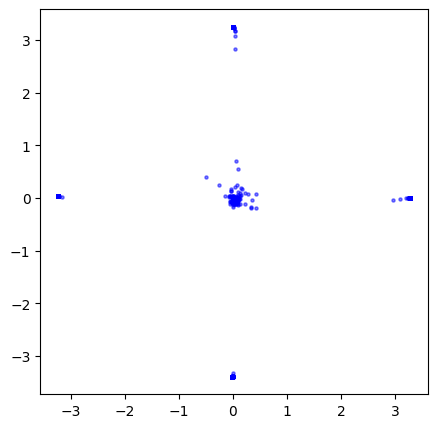

In [54]:
plt.figure(figsize=(5,5))
np_samples = samples.detach().cpu().numpy()
plt.scatter(np_samples[:,0], np_samples[:,1], s=5, alpha=0.5, color='blue')
plt.show()


/var/folders/z7/n531lrq95hq1b7t5ds_yt9b00000gn/T/ipykernel_3093/3568668732.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


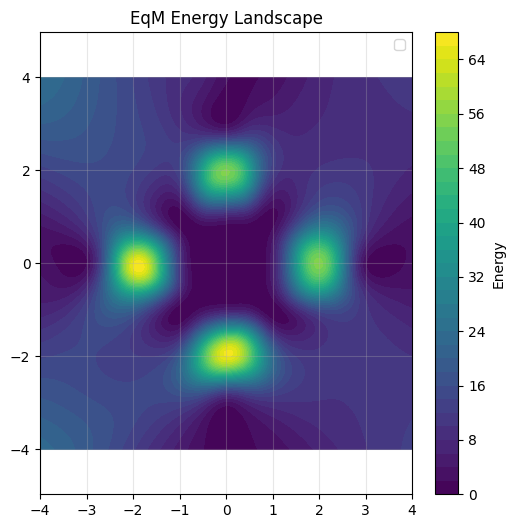

In [48]:
@torch.no_grad()
def plot_energy_contours(f_model, xrange=(-4, 4), yrange=(-4, 4), density=150):
   
    xs = torch.linspace(xrange[0], xrange[1], density)
    ys = torch.linspace(yrange[0], yrange[1], density)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

    F = f_model(grid)
    energy = 0.5 * (F ** 2).sum(dim=1)
    Z = energy.view(density, density).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.contourf(X.cpu(), Y.cpu(), Z, levels=40, cmap="viridis")
    plt.colorbar(label="Energy")
    plt.axis("equal")
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title("EqM Energy Landscape")
    plt.show()

# Plot
plot_energy_contours(f_theta, xrange=(-4, 4), yrange=(-4, 4))